# LSTM Bot

## Project Overview

In this project, you will build a chatbot that can converse with you at the command line. The chatbot will use a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. You will also learn to use pretrained word embeddings to improve the performance of the model. At the conclusion of the project, you will be able to show your chatbot to potential employers.

Additionally, you have the option to use pretrained word embeddings in your model. We have loaded Brown Embeddings from Gensim in the starter code below. You can compare the performance of your model with pre-trained embeddings against a model without the embeddings.



---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


Please choose a dataset from the Torchtext website. We recommend looking at the Squad dataset first. Here is a link to the website where you can view your options:

- https://pytorch.org/text/stable/datasets.html





In [1]:
test = False
init = False

if test:
    !pip install -U  pytest
if init:
    pass
    #!pip install torchsummary
    #!pip install typing-extensions --upgrade
    #!pip install -U torch torchvision torchtext torchdata pytest

In [2]:
# public libraries
import nltk
import numpy as np
import pandas as pd
import gzip
import torch
import torch.nn as nn
import pandas as pd
import torch.optim
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# my libraries
import src.utils
import src.data

In [3]:
# create Proof-of-Concept dataset
df_names = pd.read_csv('data/names.csv')

poc_questions = []
poc_answers = []
for i, row in list(df_names.iterrows())[:90]:
    poc_questions.append("What is your name?")
    name = row["First Name"]+" "+row["Last Name"]
    poc_answers.append(f"['My name is {name}]'")
for i, row in list(df_names.iterrows())[90:]:
    poc_questions.append("What is your name?")
    name = row["First Name"]+" "+row["Last Name"]
    poc_answers.append(f"['{name}']")
for i in range(100):
    poc_questions.append("What is your name?")
    one = random.randint(0,99)
    two = random.randint(0,99)
    name_one = df_names["First Name"].iloc[one]+" "+df_names["Last Name"].iloc[two]
    name_two = df_names["First Name"].iloc[two]+" "+df_names["Last Name"].iloc[two]
    poc_answers.append(f"['Our name is {name_one} and {name_two}']")
for i, row in list(df_names.iterrows()):
    poc_questions.append("What is her name?")
    name = row["First Name"]+" "+row["Last Name"]
    if row["Gender"] == "Female":
        poc_answers.append(f"['Her name is {name}']")
for i, row in list(df_names.iterrows()):
    poc_questions.append("What is his name?")
    name = row["First Name"]+" "+row["Last Name"]
    if row["Gender"] == "Male":
        poc_answers.append(f"['His name is {name}']'")
df_poc = pd.DataFrame(list(zip(poc_questions, poc_answers)),
               columns =['question', 'answer'])
df_poc.to_csv('data/poc_data.csv')



In [4]:
if False:
    from nltk.corpus import brown
    from nltk.tokenize import RegexpTokenizer
    import gensim


    #from ntlk.stem import *

    nltk.download('brown')
    nltk.download('punkt')

    # Output, save, and load brown embeddings

    model = gensim.models.Word2Vec(brown.sents())
    model.save('brown.embedding')

    w2v = gensim.models.Word2Vec.load('brown.embedding')



    def loadDF(path):
      '''

      You will use this function to load the dataset into a Pandas Dataframe for processing.

      '''
      return df


    def prepare_text(sentence):

        '''

        Our text needs to be cleaned with a tokenizer. This function will perform that task.
        https://www.nltk.org/api/nltk.tokenize.html

        '''

        return tokens



    def train_test_split(SRC, TRG):

        '''
        Input: SRC, our list of questions from the dataset
                TRG, our list of responses from the dataset

        Output: Training and test datasets for SRC & TRG

        '''
        share = 0.2
        src_split = len(SRC)*share
        trg_split = len(TRG)*share
        SRC_test_dataset = SRC[:scr_split]
        SRC_train_dataset = SRC[scr_split:]
        TRG_test_dataset = SRC[:trg_split]
        TRG_train_dataset = SRC[trg_split:]


        return SRC_train_dataset, SRC_test_dataset, TRG_train_dataset, TRG_test_dataset


### Get and watch the data

In [5]:
if init:
    data.squad1_to_csv()
    
df_train = pd.read_csv('data/train_dataset_squad1.csv')  
# df_train = pd.read_csv('data/poc_data.csv')  
df_test = pd.read_csv('data/dev_dataset_squad1.csv') 
# df_test = pd.read_csv('data/poc_data.csv')
split = round(len(df_train)*100/(len(df_train)+len(df_test)),1)
print(f"{len(df_train)} training samples and {len(df_test)} have been loaded.")
print(f"The test data makes {split}% of all the data.")
df_train.head()

87599 training samples and 10570 have been loaded.
The test data makes 89.2% of all the data.


,Unnamed: 0,context,question,answer,answer_start
0,0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,['Saint Bernadette Soubirous'],[515]
1,1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,['a copper statue of Christ'],[188]
2,2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,['the Main Building'],[279]
3,3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,['a Marian place of prayer and reflection'],[381]
4,4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,['a golden statue of the Virgin Mary'],[92]


### Data Analysis

In [6]:
vocab_prep = src.utils.Vocab(name='prepration')
raw_questions = [vocab_prep.clean_text(s) for s in df_train["question"].values.tolist()]
raw_answers = [vocab_prep.clean_text(q[2:-2]) for q in df_train["answer"].values.tolist()]

(array([1.6140e+03, 2.9118e+04, 3.6943e+04, 1.4995e+04, 3.8720e+03,
        8.2300e+02, 1.7400e+02, 4.7000e+01, 1.0000e+01, 3.0000e+00]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <BarContainer object of 10 artists>)

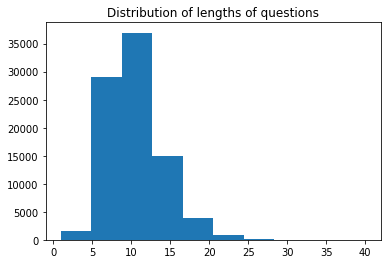

In [7]:
# Source Data
plt.title("Distribution of lengths of questions")
plt.hist(np.array([len(n) for n in raw_questions]))

(array([7.1253e+04, 1.0344e+04, 3.0790e+03, 1.7480e+03, 6.9000e+02,
        3.9300e+02, 9.0000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ]),
 <BarContainer object of 10 artists>)

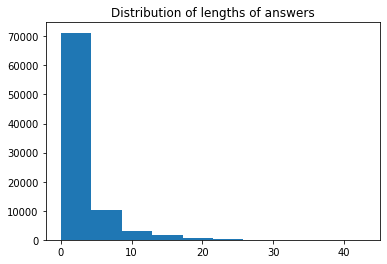

In [8]:
# Target Data
plt.title("Distribution of lengths of answers")
plt.hist(np.array([len(n) for n in raw_answers]))

### Filtering out of noise

I remove all questions with less than 25 words and all answers with less than 13 words (together with their counterpart).

In [9]:
index_a = [index for index, row in enumerate(raw_questions) if len(row) < 25]
index_b = [index for index, row in enumerate(raw_answers) if len(row) < 13]

index_all=list(set(index_a).intersection(set(index_b)))
share = round(((len(df_train)-len(index_all))/len(df_train))*100,1)
df_train_filtered = df_train.iloc[index_all]
print(f"We have removed {share}% of the data.")

We have removed 3.6% of the data.


### Tokenization

In [10]:
# we have to repeat this step with the filtered dataframe
raw_questions = [vocab_prep.clean_text(s) for s in df_train_filtered["question"].values.tolist()]
raw_answers = [vocab_prep.clean_text(q[2:-2]) for q in df_train_filtered["answer"].values.tolist()]

In [11]:
sequence_length_source = src.utils.get_max_length(raw_questions) + 2
sequence_length_target = src.utils.get_max_length(raw_answers) + 1
print(f"The source sequence has to have a length of {sequence_length_source}. And the target sequence has to have a length of {sequence_length_target}.")

The source sequence has to have a length of 26. And the target sequence has to have a length of 13.


In [12]:
vocab_source = src.utils.Vocab(name='source')
vocab_target = src.utils.Vocab(name='target')

count = 0
for q, a in zip(raw_questions, raw_answers):

    PAD = "<PAD>"
    SOS = "<SOS>"
    EOS = "<EOS>"
    OUT = "<OUT>"
    special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<OUT>"]
    for word in special_tokens + q:
        vocab_source.indexWord(word)
    for word in special_tokens + a:
        vocab_target.indexWord(word)

print("source:", len(vocab_source.words), "target:", len(vocab_target.words), "common words:", len(list(set(vocab_source.words.keys()).intersection(set(vocab_target.words.keys())))))

questions = src.utils.tokenize_questions(raw_questions, vocab_source)
answers = src.utils.tokenize_answers(raw_answers, vocab_target)


source: 41290 target: 40330 common words: 23332


### Tests

In [13]:
if test:
    !python -m pytest -vv tests.py

### Defining the model

In [14]:
import torch.nn as nn
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        
        super(Encoder, self).__init__()
        
        # self.embedding provides a vector representation of the inputs to our model
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # self.lstm, accepts the vectorized input and passes a hidden state
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=0.0)
        
    
    def forward(self, i, h):
        
        '''
        Inputs: i, the src vector
        Outputs: o, the encoder outputs
                h, the hidden state (actually a tuple of hidden state and cell state)
        '''
        embedding = self.embedding(i)
        x,y = h
        o, h= self.lstm(embedding, h)
        o = self.dropout(o)
        
        return o, h
    

class Decoder(nn.Module):
      
    def __init__(self, hidden_size, output_size):
        
        super(Decoder, self).__init__()
        
        # self.embedding provides a vector representation of the target to our model
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # self.lstm, accepts the embeddings and outputs a hidden state
        self.lstm = nn.LSTM(hidden_size, hidden_size)

        # self.ouput, predicts on the hidden state via a linear output layer  
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, i, h):
        
        '''
        Inputs: i, the target vector
        Outputs: o, the decoder output
                h, the hidden state (actually a tuple of hidden state and cell state)
        '''

        embedding = self.embedding(i)

        o, h = self.lstm(embedding, h)

        o = self.linear(o)

        o = self.softmax(o)

        
        return o, h
        
        

class Seq2Seq(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
                
        
    
    
    def forward(self, src, trg, start, teacher_forcing_ratio = 0.5): 
        '''
        Inputs: src, the source vector
                trg, the target vector
        Outputs: o, the prediction
                
        '''
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        src.to(device)
        trg.to(device)
        start.to(device)
        
            
        
        # encoder
        hidden = (torch.zeros(1,hidden_size).to(device), torch.zeros(1,hidden_size).to(device))
        for word in src:
            #print("word",word.shape,word)
            o, hidden = self.encoder(word.view(-1).to(device), hidden)
        
        # decoder
        o = start
        
        prediction = []
        for word in trg:
            #print("o", o)
            #print("o.view(-1)",o.view(-1))
            o, hidden = self.decoder(o.view(-1).to(device), hidden)
            prediction.append(o)

            if self.training:
                o = word if random.random() < teacher_forcing_ratio else torch.argmax(o,dim=1)
            else:
                o = torch.argmax(o,dim=1)
            

            
        
        return torch.stack(prediction).squeeze(1)

    



### Training

In [15]:
len(raw_answers)
questions = src.utils.tokenize_questions(raw_questions, vocab_source)
answers = src.utils.tokenize_answers(raw_answers, vocab_target)

In [16]:
answers.shape

torch.Size([84453, 13])

In [17]:
batch_size = 32
loader = DataLoader(list(zip(raw_questions, raw_answers)), shuffle = False, batch_size = batch_size)
print(len(loader))

2640


In [ ]:
from pathlib import Path

questions = src.utils.tokenize_questions(raw_questions, vocab_source)
answers = src.utils.tokenize_answers(raw_answers, vocab_target)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_cuda = torch.cuda.is_available()
#is_cuda = False
print("is cuda:",is_cuda)


# hyperparams
epochs = 100

batch_size = 32
hidden_size = 64
lr = 0.01
teacher_forcing_ratio = 0.5
print_each = 100


loader  = DataLoader(list(zip(questions, answers)), shuffle = False, batch_size = batch_size)

#print(loader.shape)


# model
input_size = len(vocab_source.words)
hidden_size = hidden_size
output_size = len(vocab_target.words)
model = Seq2Seq(input_size, hidden_size, output_size)


if Path("checkpoints/model_1.pt").is_file():
    model.load_state_dict(torch.load("checkpoints/model_1.pt"))
    print("loading from checkpoint: ''checkpoints/model_1.pt'")
else:
    print("nothing to load at checkpoint: 'checkpoints/model_1.pt'")

model.to(device)
# training

optim = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()
model.train()
epoch = 0
for epoch in range(epochs):

    for batch_i, (questions, answers) in enumerate(loader):
        batch_loss = 0
        #outputs = []
        for q, a in zip(questions, answers):       
            start = next(iter(torch.LongTensor([vocab_target.words["<SOS>"]])))
            optim.zero_grad()
            output = model(q,a,start)
            
            rand = random.uniform(0,1)
            loss = loss_fn(output, a.to(device))
            loss.backward(retain_graph=True)
            optim.step()
            batch_loss += loss.item()
            #outputs.append([output])
        if batch_i % print_each == 0:
            share = round(((batch_i+print_each)*100)/len(loader),1)
            print(" ")
            print("epoch", epoch, "batch#",batch_i,"batch loss:",batch_loss/batch_size, f"{share}% samples processed")
            text = ""
            for x in q:
                text += vocab_source.index[str(x.item())] + " "
            print("question",text)
            text = ""
            for x in a:
                #print(x)
                text += vocab_target.index[str(x.item())] + " "
            print("answer:", text)
            text = ""
            for x in output:
                #print(x)
                text += vocab_target.index[str(torch.argmax(x,dim=0).item())] + " "
            print("prediction:", text)
        if batch_i % 200 == 0:
            torch.save(model.state_dict(),"checkpoints/model_1.pt")
                  


            

is cuda: True
loading from checkpoint: ''checkpoints/model_1.pt'
 
epoch 0 batch# 0 batch loss: -2.329357948838151e-05 1.9% samples processed
question <SOS> In what year was the Joan B Kroc Institute for International Peace Studies founded <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
answer: 1986 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
prediction: Hochbunker Isidore mistake billion Mahbub Nancy Postes Postes Postes heads employment ParkScore scream 
 
epoch 0 batch# 50 batch loss: -2.3327382280058373e-05 3.8% samples processed
question <SOS> What year did Chopin s sister Emilia die <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
answer: 1827 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
prediction: Hochbunker renouncing dynamic Thapa heads heads employment heads 143 1968 ammattikorkeakoulus kingdoms kingdoms 
 
epoch 0 batch# 100 batch loss: -2.301866

In [ ]:
30000/205


In [ ]:
vocab_target.index

In [ ]:
# from pathlib import Path

# questions = src.utils.tokenize_questions(questions, vocab_source)
# answers = src.utils.tokenize_answers(answers, vocab_target)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# is_cuda = torch.cuda.is_available()
# #is_cuda = False
# print("is cuda:",is_cuda)


# # hyperparams
# epochs = 1

# batch_size = 32
# hidden_size = 2
# lr = 0.01
# teacher_forcing_ratio = 0.5
# loader  = DataLoader(list(zip(questions, answers)), shuffle = False, batch_size = batch_size)
# print


# # model
# input_size = len(vocab_source.words)
# hidden_size = hidden_size
# output_size = len(vocab_target.words)
# model = Seq2Seq(input_size, hidden_size, output_size)


# if Path("./checkpoints/model_1.pt").is_file():
#     model.load_state_dict(torch.load("./checkpoints/model_1.pt"))
#     print("loading from checkpoint: ''./checkpoints/model_1.pt'")
# else:
#     print("nothing to load at checkpoint: './checkpoints/model_1.pt'")

# model.to(device)
# # training

# optim = torch.optim.SGD(model.parameters(), lr=lr)
# loss_fn = nn.NLLLoss()
# model.train()
# epoch = 0
# for epoch in range(epochs):

#     for batch_i, (questions, answers) in enumerate(loader):
#         batch_loss = 0
#         for q, a in zip(questions, answers):       
#             start = next(iter(torch.LongTensor([vocab_target.words["<SOS>"]])))
#             optim.zero_grad()
#             output = model(q,a,start)
            
#             rand = random.uniform(0,1)
#             loss = loss_fn(output, a.to(device))
#             loss.backward(retain_graph=True)
#             optim.step()
#             batch_loss += loss.item()
#             #print("loss:",loss.item())
#         if batch_i % 50 == 0:
#             share = round((batch_size * batch_i)/len(questions)*100,1)
#             print("batch#",batch_i,"batch loss:",batch_loss/batch_size, f"{share}% samples processed")
#         if batch_i % 200 == 0:
#             torch.save(model.state_dict(),"./checkpoints/model_1.pt")
                  


            
        

In [ ]:
print(qt)
print(trg)
print(hidden)

In [ ]:
torch.cuda.memory_summary(device='cuda', abbreviated=False)

In [ ]:
t = torch.Tensor(2)
#t = t.view(1,-1)
t.shape
t=t.view()
t


In [ ]:
at = at.view(-1)
output = output.squeeze(0)
print(at.shape)
print(output.shape)
loss_fn(output,at)

In [ ]:
for que in questions[:2]:
    for word in que:
        print(word.shape, word.view(-1).shape,word.view(1,-1).shape,word.view(1,-1), word.view(1,1,-1).shape)

In [ ]:
import src.abc
src.abc.test()

In [ ]:
import torch.nn.functional as F
F.one_hot(torch.Tensor([19]),50)